In [652]:
# Нужные библиотеки
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dl
import torchvision
import torchvision as tv
import torchvision.transforms as transforms

import numpy as np
import os
import cv2
from tqdm import tqdm

from PIL import Image
import matplotlib.pyplot as plt

In [638]:
if torch.cuda.is_available():
  print("You can use cuda")
  device = torch.device("cuda")
else:
  print("You cant use only cpu")
  device = torch.device("cpu")

You can use cuda


In [639]:
print(torch.version.cuda)

12.1


In [640]:
# Делаем массив с нашими классами для нейросети
root_classes = []
for class_name in sorted(os.listdir('dataset/')):
      root_classes.append(class_name)
print(len(root_classes))      

82


In [641]:
class CustomDataset(dl.Dataset):
  def __init__(self, root_dir, transform=None):
    super(CustomDataset, self).__init__()
    
    self.transform = transform
    self.data_dir = root_dir
    self.classes = sorted(os.listdir(root_dir))
    self.images = []
    self.labels = []
    
    for class_dir in self.classes:
      class_path = os.path.join(root_dir, class_dir)
      
      if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
          image_path = os.path.join(class_path, img_name)
          self.images.append(image_path)
          self.labels.append(class_dir)
                  
    
  def __len__(self):
    return len(self.images)
  
  
  def __getitem__(self, idx):
    image_path = self.images[idx]
    item_id = root_classes.index(self.labels[idx])
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    image = image.astype(np.float32)
    image = image / 255.0
    
    image = cv2.resize(image, (64, 64), interpolation=cv2.INTER_AREA)
    
    if self.transform is not None:
      image = self.transform(image)
      
    item_id = torch.tensor(item_id)
    
    return image, item_id
    

In [642]:
trans = transforms.Compose([
  transforms.ToTensor()
])

In [643]:
custom_dataset = CustomDataset(root_dir='dataset/', transform=trans)

9


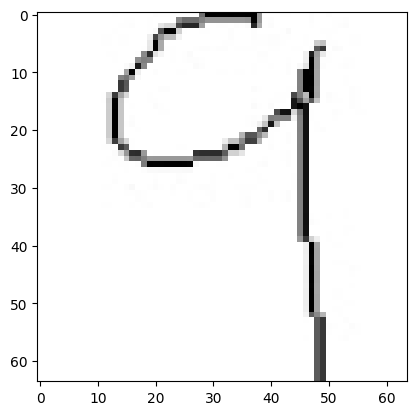

In [644]:
img = custom_dataset[182311]
print(root_classes[img[1].numpy()])
plt.imshow(img[0].numpy()[0], cmap='gray')

In [645]:
num_epochs = 3

batch_size = 16
num_workers = 0
learning_rate = 1e-3
bet = (0.9, 0.999)

In [646]:
train_loader = torch.utils.data.DataLoader(dataset=custom_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=num_workers,
                                           drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset=custom_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=num_workers,
                                          drop_last=False)

In [659]:
class ConvNS(nn.Module):
    def __init__(self):
        super(ConvNS, self).__init__()

        self.act = nn.LeakyReLU()
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2)
        self.conv1 = nn.Conv2d(32, 32, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2)
        
        self.adaptive = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(128, 1024)
        self.linear2 = nn.Linear(1024, 82)

    def forward(self, x):
        out = self.conv0(x)
        out = self.act(out)
        out = self.pool(out)
        
        out = self.conv1(out)
        out = self.act(out)
        out = self.pool(out)
        
        out = self.conv2(out)
        out = self.act(out)
        out = self.pool(out)
        
        out = self.conv3(out)
        out = self.act(out)
        out = self.pool(out)
        
        out = self.adaptive(out)
        out = self.flatten(out)
        out = self.linear1(out)
        out = self.act(out)
        out = self.linear2(out)
        
        return out

In [664]:
model = ConvNS().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=bet)

In [665]:
print(len(train_loader))
total_step = len(train_loader)

23498


In [666]:
def accuracy(pred, label):
  answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1)
  return answer.mean()

In [667]:
lost_item = 0
acc_cur = 0
for epoch in range(num_epochs):
    los_val = 0
    acc_val = 0
    for img, label in (pbar := tqdm(train_loader)):
        optimizer.zero_grad()

        label = F.one_hot(label, 82).float().to(device)
        img = img.to(device)

        pred = model(img)

        loss = loss_func(pred, label)

        loss.backward()
        lost_item = loss.item()
        los_val += lost_item

        optimizer.step()

        acc_cur = accuracy(pred.cpu(), label.cpu())
        acc_val += acc_cur

    pbar.set_description(f'loss: {lost_item:.4f}\nacc: {acc_cur:.4f}')
    print(los_val / len(train_loader))
    print(acc_val / len(train_loader))

  0%|          | 0/23498 [00:00<?, ?it/s]C:\Users\owtf0\AppData\Local\Temp\ipykernel_30248\1616411522.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1)
100%|██████████| 23498/23498 [02:50<00:00, 138.03it/s]


0.3037045045657323
0.9123249851051153


100%|██████████| 23498/23498 [02:56<00:00, 133.26it/s]


0.12261297399650661
0.9607572984934888


100%|██████████| 23498/23498 [03:07<00:00, 125.12it/s]

0.09531754758993036
0.969218124946804


In [668]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy {} %'.format((correct / total) * 100))

Test Accuracy 97.44716389963136 %


In [681]:
# Сохранение модели
model_save_path = 'models/expr_convnet.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to models/expr_convnet.pth


In [682]:
test_img = custom_dataset[3501][0].numpy()[0]
test_img = cv2.resize(test_img, (64, 64), interpolation=cv2.INTER_AREA)

(64, 64)


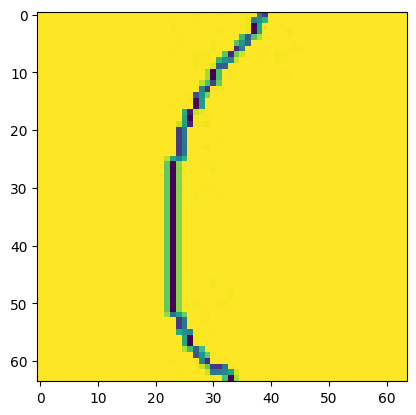

In [683]:
print(test_img.shape)
plt.imshow(test_img)

In [684]:
test_img = np.expand_dims(test_img, axis=0)
test_img = np.expand_dims(test_img, axis=0)
print(test_img.shape)

(1, 1, 64, 64)


In [685]:
torch_img = torch.from_numpy(test_img).to(device)
test_model = model(torch_img).to(device)

In [686]:
idx = F.softmax(test_model.to("cpu")).detach().numpy().argmax()
root_classes[idx]

C:\Users\owtf0\AppData\Local\Temp\ipykernel_30248\4108523807.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  idx = F.softmax(test_model.to("cpu")).detach().numpy().argmax()


'('